# Inverse UQ example: Shocktube

In [35]:
L_max = 20
n_L = 8
n_T = 5
T_max = 5

# The larger this is, the more noise there is in the measurements.
sigma = 0.5

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import umbridge as um
from matplotlib.animation import FuncAnimation
from Riemann import RiemannProblem

from scipy.integrate import solve_ivp

import tinyDA as tda

In [37]:
np.random.seed(44)

We implement two slightly incompatible models. `UmbridgeArepoModel` obeys the UM-Bridge interface, and `NpArepoModel` is a wrapper that is compatible with tinyDA.

In [38]:
class UmbridgeArepoModel(um.Model):
    def __init__(self):
        super().__init__("forward")

    def get_input_sizes(self, config):
        return [4]
    
    def get_output_sizes(self, config):
        return [4]
    
    def __call__(self, parameters, config={}):
        RESOLUTION = 200
        input = parameters[0]
        rho_L, v_L, p_L = input[0]
        rho_R, v_R, p_R = input[1]
        T_max, n_T = input[2]
        L_max, n_L = input[3]

        time = np.linspace(0, T_max, n_T + 1)
        solutions = [
            RiemannProblem(np.linspace(0, L_max, RESOLUTION), L_max / 2.0, [rho_L, v_L, p_L], [rho_R, v_R, p_R], 1.4, t)[1]
            for t in time
        ]

        def convert_space_index(input):
            return int(input * (RESOLUTION - 1) / n_L)

        return [
            [
                [], # x coordinates
                [
                    [
                        solutions[t][convert_space_index(s), 0] # 0 = density
                        for s in range(n_L + 1)
                    ]
                    for t in range(len(time))
                ],
                [
                    [
                        solutions[t][convert_space_index(s), 2] # 1 = velocity
                        for s in range(n_L + 1)
                    ]
                    for t in range(len(time))
                ],
                [
                    [
                        solutions[t][convert_space_index(s), 1] # 2 = pressure
                        for s in range(n_L + 1)
                    ]
                    for t in range(len(time))
                ]
            ]
        ]

    def supports_evaluate(self):
        return True
    
class NpArepoModel(um.Model):
    def __init__(self, inner_model, n_L=5, n_T=20, L_max=20, T_max=20, verbose=False):
        self.inner = inner_model
        self.n_L = n_L
        self.n_T = n_T
        self.L_max = L_max
        self.T_max = T_max
        self.verbose = verbose

    def __call__(self, parameters):
        left = [0, 0, 0]
        right = [0, 0, 0]
        left[0] = np.clip(parameters[0], 1e-2, 1)
        left[1] = 0.0
        left[2] = np.clip(parameters[1], 1e-2, 1)
        right[0] = np.clip(parameters[2], 1e-2, 1)
        right[1] = 0.0
        right[2] = np.clip(parameters[3], 1e-2, 1)
        inner_args = [[left, right, [self.T_max, self.n_T], [self.L_max, self.n_L]]]
        if self.verbose:
            print("Inner input:")
            print(inner_args)
        inner_result = np.array(self.inner(inner_args)[0][2])
        if self.verbose:
            print("Inner output:")
            print(inner_result)
        if inner_result.shape[0] != self.n_T + 1:
            raise ValueError(f"Expected n_T + 1 = {self.n_T + 1} time steps, but got {inner_result.shape[0]}")
        if inner_result.shape[1] != self.n_L + 1:
            raise ValueError(f"Expected n_L + 1 = {self.n_L + 1} spatial steps, but got {inner_result.shape[1]}")
        return np.array(inner_result).flatten(), True

# Visualize the exact model

In [39]:
test_model_exact = UmbridgeArepoModel()
test_model_simulation = um.HTTPModel("http://localhost:4242", "shockwave1D")

models = [
    [test_model_exact, "Exact"],
    [test_model_simulation, "Simulation"],
]

# Set up the figure and axis
fig, axes = plt.subplots(2, len(models), figsize=(10, 6))
plt.subplots_adjust(hspace=0.6)
if len(axes.shape) == 1:
    axes = [axes]

results = []
lines = []
for [rho_axis, p_axis], [model, name] in zip(axes, models):
    inner_results = []
    inner_lines = []
    model_results = model([[[1.0, 0.0, 1.0], [0.125, 0.0, 0.1], [T_max, n_T], [L_max, n_L]]])[0]
    for [ax, text, i] in zip([rho_axis, p_axis], ["Density", "Pressure"], [1, 2]):
        line, = ax.plot([], [], 'b-')
        ax.set_xlim(0, L_max)
        ax.set_ylim(0, 1.1)  # Adjust as needed
        ax.set_title(f'{name}/{text}')
        ax.set_xlabel('Position')
        ax.set_ylabel(text)
        ax.grid(True)
        inner_lines.append(line)
        inner_results.append(model_results[i])
    results.append(inner_results)
    lines.append(inner_lines)

# Animation update function
def update(frame):
    t = frame
    for [rho_axis, p_axis], inner_results, inner_lines, [model, name] in zip(axes, results, lines, models):
        for [ax, result, line] in zip([rho_axis, p_axis], inner_results, inner_lines):
            pressure = result[t]
            line.set_data(np.linspace(0, L_max, n_L + 1), pressure)
            ax.set_title(f'{name} Distribution (t = {t:.3f})')
    return []

# Create the animation
anim = FuncAnimation(fig, update, frames=n_T + 1, interval=50, blit=True)

plt.close()

# Display the animation
from IPython.display import HTML
HTML(anim.to_jshtml())

### Set up the exact and numerical model

In [40]:
# set the true parameters. Our (noisy) measurements are based on these.
rho_L = 0.8 # initial density of the left half
p_L = 0.8 # initial pressure of the left half
rho_R = 0.125 # initial density of the right half
p_R = 0.1 # initial pressure of the right half

# collect the parameters in a vector. 
# we sample the log of the parameters and take the exponential
# inside the model to keep the parameters positive.
true_parameters = np.array([rho_L, p_L, rho_R, p_R])

my_exact_model = NpArepoModel(UmbridgeArepoModel(), n_L=n_L, n_T=n_T, L_max=L_max, T_max=T_max)

# initalise the true model and solve it
http_model = um.HTTPModel("http://localhost:4242", "shockwave1D")
my_model = NpArepoModel(http_model, n_L=n_L, n_T=n_T, L_max=L_max, T_max=T_max, verbose=False)
# my_model = NpArepoModel(UmbridgeArepoModel(), n_L=n_L, n_T=n_T, L_max=L_max, T_max=T_max, verbose=False)
y_true = my_model(true_parameters)[0]
y_true

array([0.8       , 0.8       , 0.8       , 0.8       , 0.1       ,
       0.1       , 0.1       , 0.1       , 0.1       , 0.8       ,
       0.8       , 0.8       , 0.79998493, 0.27463136, 0.1000025 ,
       0.1       , 0.1       , 0.1       , 0.8       , 0.8       ,
       0.8       , 0.74633864, 0.27500284, 0.27525007, 0.1       ,
       0.1       , 0.1       , 0.8       , 0.8       , 0.79984943,
       0.50462282, 0.27500679, 0.27498167, 0.13995571, 0.1       ,
       0.1       , 0.8       , 0.79999989, 0.77204774, 0.37130091,
       0.2750504 , 0.2750175 , 0.2749784 , 0.10000416, 0.1       ,
       0.8       , 0.79978029, 0.63874506, 0.30697795, 0.27503956,
       0.27505655, 0.27503021, 0.27497153, 0.1       ])

### Generate data

In [41]:
# set the noise level
experimental_measurements = np.array(my_exact_model(true_parameters)[0])

noise = np.random.normal(scale=sigma, size=experimental_measurements.size) # fine noise
data = experimental_measurements + noise # noisy fine data.
data[data < 0] = 0 # make sure all the data is positive.

### Set up the statistical model  and draw some samples from the prior
Our prior is that the pressure and density parameters are uniformly distributed between 0 and 1.


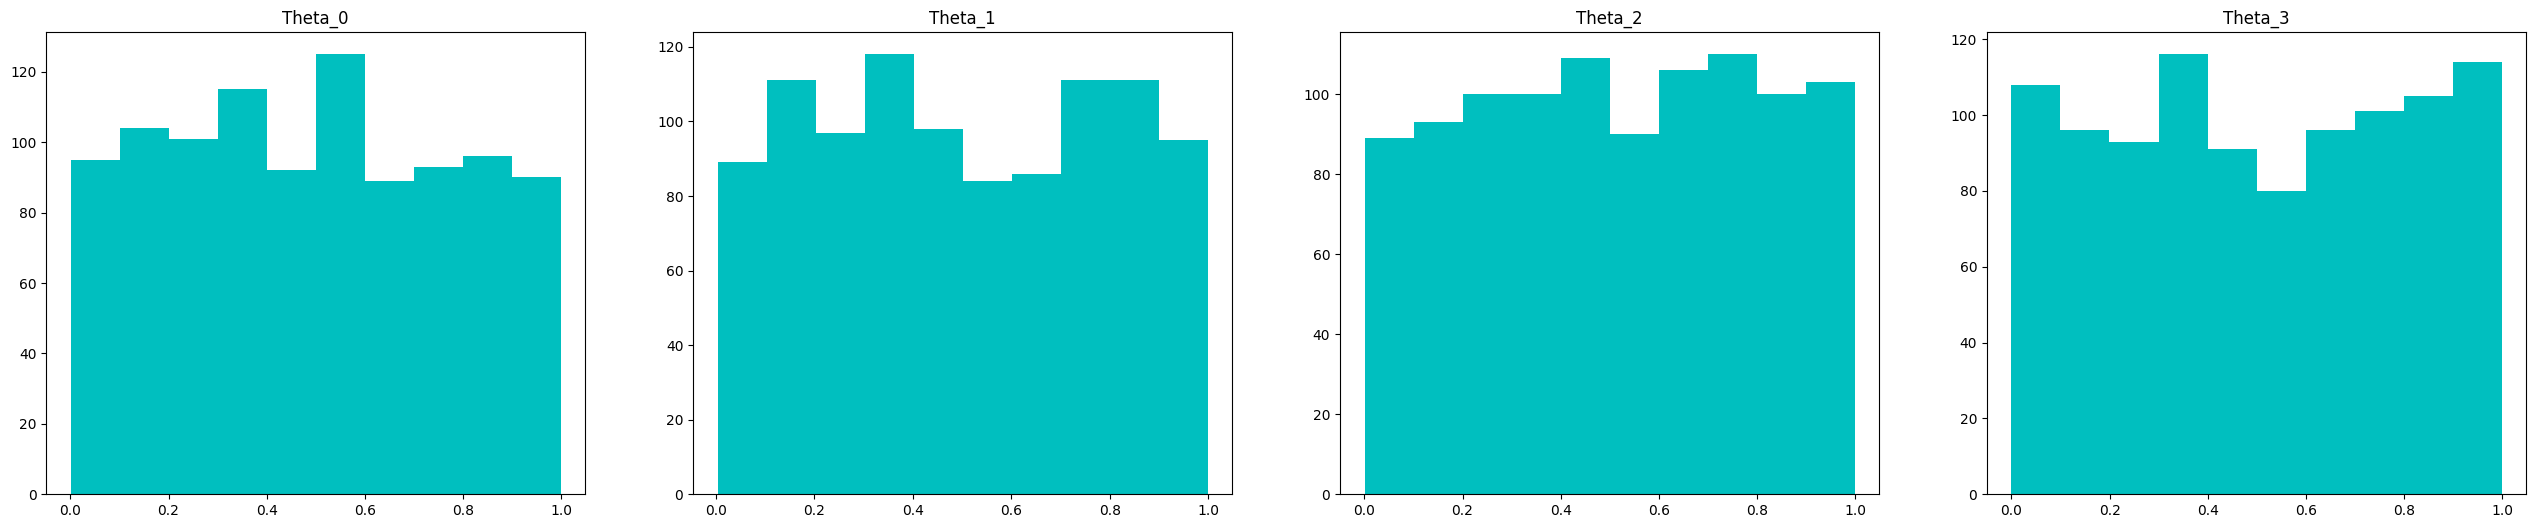

In [42]:
class MultivariatePrior:
    def __init__(self, low, high):
        self.low = np.array(low)
        self.high = np.array(high)
        self.dim = len(low)

    def logpdf(self, x):
        x = np.array(x)
        in_range = np.all((x >= self.low) & (x <= self.high))
        return 0 if in_range else -np.inf  # np.where(in_range, 0, -np.inf)

    def rvs(self, size=1):
        if isinstance(size, int):
            size = (size, self.dim)
        elif isinstance(size, tuple) and len(size) == 1:
            size = size + (self.dim,)
        samples = np.random.uniform(self.low, self.high, size=size)
        if size == 1 or (isinstance(size, tuple) and size[0] == 1):
            return samples[0]
        return samples

# Set up the prior
low = np.array([0, 0, 0, 0])
high = np.array([1, 1, 1, 1])
my_prior = MultivariatePrior(low, high)

# draw some samples and plot them
prior_samples = my_prior.rvs(size=(1000, 4))
fig, axes = plt.subplots(nrows=1, ncols=4, figsize = (8*4, 6))
for i in range(4):
    axes[i].set_title('Theta_{}'.format(i))
    axes[i].hist(prior_samples[:,i], color='c')

In [43]:
# define the likelihood
cov_likelihood = sigma**2*np.eye(data.size)

my_loglike = tda.GaussianLogLike(data, cov_likelihood)

### Set up the link factories and get the MAP point

In [44]:
# set up the link factories
my_posterior = tda.Posterior(my_prior, my_loglike, my_model)

my_posteriors = [my_posterior]

In [45]:
# get the maximum a posteriori point.
MAP = tda.get_MAP(my_posterior)
MAP

/home/paul/temp/jupyter-kernels/dasci/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
/home/paul/temp/jupyter-kernels/dasci/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
/home/paul/temp/jupyter-kernels/dasci/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0
/home/paul/temp/jupyter-kernels/dasci/lib/python3.10/site-packages/scipy/optimize/_numdiff.py:592: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


array([0.99592171, 0.68279062, 0.1926056 , 0.31024611])

### Set up the proposal

In [46]:
# random walk Metropolis
# rwmh_cov = np.eye(4)
# rmwh_scaling = 0.1
# rwmh_adaptive = True
# my_proposal = tda.GaussianRandomWalk(C=rwmh_cov, scaling=rmwh_scaling, adaptive=rwmh_adaptive)

# preconditioned Crank-Niconson
#pcn_scaling = 0.1
#pcn_adaptive = True
#my_proposal = tda.CrankNicolson(scaling=pcn_scaling, adaptive=pcn_adaptive)

# Adaptive Metropolis
am_cov = np.eye(true_parameters.size)
am_t0 = 100
am_sd = None
am_epsilon = 1e-6
am_adaptive = True
my_proposal = tda.AdaptiveMetropolis(C0=am_cov, t0=am_t0, sd=am_sd, epsilon=am_epsilon)

### Sample

In [47]:
import os
if "CI" in os.environ:
    iterations = 120
    burnin = 20
else:
    iterations = 12000
    burnin = 2000


In [50]:
# initialise the chain
my_chain = tda.sample(my_posteriors, my_proposal, iterations=iterations, n_chains=2, initial_parameters=MAP, subchain_length=5, adaptive_error_model='state-independent', force_sequential=True)

Sampling chain 1/2


Running chain, α = 0.24: 100%|██████████| 12000/12000 [2:54:01<00:00,  1.15it/s] 


Sampling chain 2/2


Running chain, α = 0.30: 100%|██████████| 12000/12000 [2:50:42<00:00,  1.17it/s] 


### Diagnostics

In [51]:
import arviz as az
print(my_chain['chain_0'][0].prior)
idata = tda.to_inference_data(my_chain, level='fine', burnin=burnin)
az.summary(idata)

0


/home/paul/temp/jupyter-kernels/dasci/lib/python3.10/site-packages/arviz/data/inference_data.py:157: UserWarning: qoi group is not defined in the InferenceData scheme
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,0.456,0.315,0.022,0.962,0.009,0.007,1095.0,1541.0,1.0
x1,0.707,0.112,0.505,0.918,0.004,0.003,982.0,1518.0,1.0
x2,0.546,0.239,0.151,0.960,0.008,0.006,783.0,1337.0,1.0
x3,0.299,0.102,0.101,0.484,0.003,0.002,858.0,1240.0,1.0


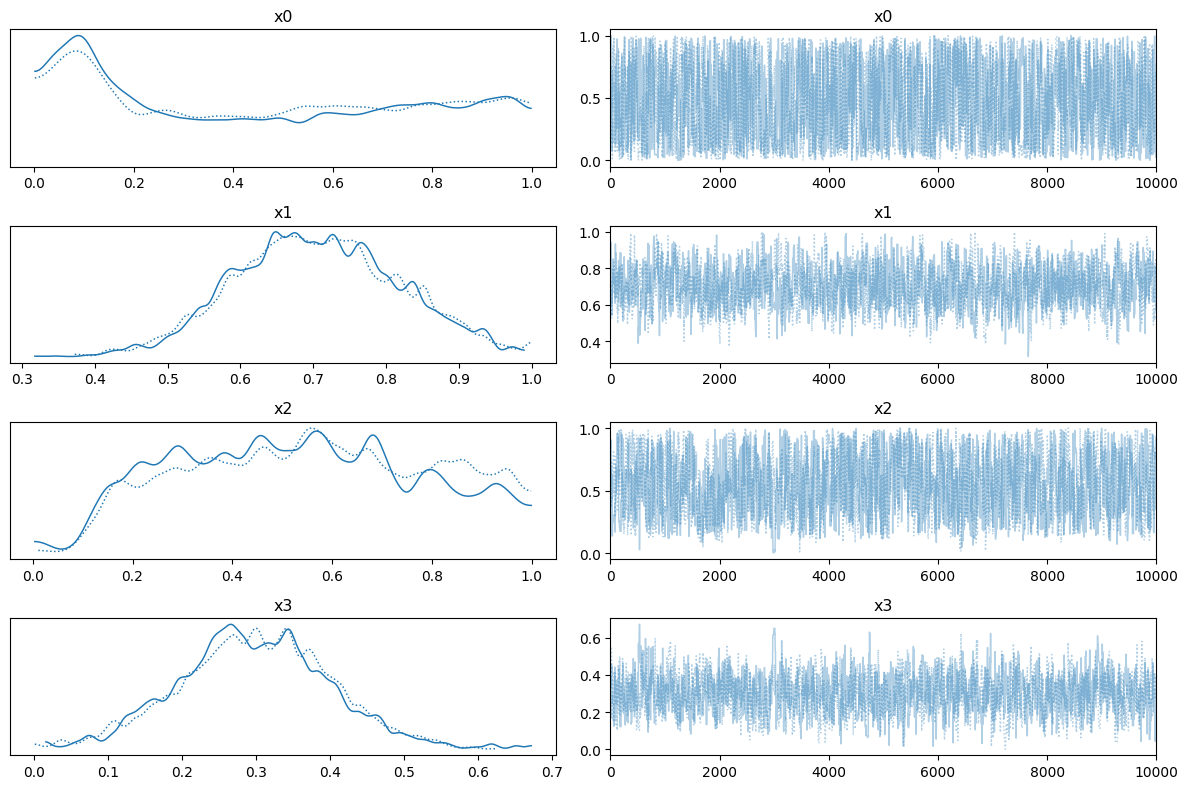

In [52]:
az.plot_trace(idata)
plt.tight_layout()
plt.show()